# Mimic multivariate time series by AR1 noise

## As in 1D, we estimate B from lagged covariance fitting exp(-Bt) decay.
Reasoning in 1D: 

Red noise has covariance that drops off exponentially with lag. So if $C_0$ is the variance of the series, and $C_{\tau_0}$ the covariance of the series with a time lag $\tau_0$, we want to know the value of $b = 1/\tau_{efold}$ for which this is the best fit: 

$$C_{\tau_0}/C_0 = exp(-b \tau_0)$$

Solving, $$b = 1/{\tau_0} ln(C_{\tau_0}/C_0)$$

The best forecast one can make of such *red noise* is $$R(t) = R(0) exp(-bt)$$

and we can build a *sequence* of red noise values by a Markov chain: the next value is exp(-bt) times the present value, plus some unpredictable noise:

$$ R(i+1) = R(i) exp(-bt) + W_i$$


where W is an unconditional (white) random number or 'noise'. See a BAMS article by Wunsch for instance, at http://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281999%29080%3C0245%3ATIOSCR%3E2.0.CO%3B2

---
Analogous reasoning in 2D: 

By analogy, covariance in multivariate red noise will decay exponentially in time, but now it is the covariance **matrix** that is postulated to decay according to a **matrix exponential** decay fuction.  

Suppose **d** is a 2D array of time series columns.

$\mathbf{C_0}$ = cov(**d , d**) is the *covariance matrix at zero lag.*  

$\mathbf{C_1}$ = cov(**d[1:-1 ,:] , d[0:-2, :]**) is *lag-1 covariance.*

Now we just need the **matrix logarithm** to estimate the decay matrix $\mathbf{B} = \mathbf{ln}(\mathbf{C_1} \mathbf{C_0}^{-1})$. 

Then the best forecast of the data from time step i, looking ahead by t timesteps lead time, will be 

$$ \mathbf{R}(i+t) = \mathbf{R}(i) exp(- \mathbf{B}t) + \mathbf{W}_i$$

Again we could build realizations by stepping forward in time from an initial anomaly $\mathbf{R}(i)$, using a random number generator to build noise vectors $\mathbf{W}_i$ to add to the always exponentially decaying signal from the prior time step. The one complication is that this noise $\mathbf{W}_i$ has *spatial structure* (that is, it has covariance among the various time series columns in the incoming data used to estimate $\mathbf{C_0}$ and $\mathbf{C_1}$). 

A paper on the deeper theory behind this is Penland and Sardeshmukh (1995). But the material above should make the form of the formula not too surprising. 

### Work in a pylab session: clean basic tools

In [1]:
# This %pylab magic line loads numpy, scipy, matplotlib. 
# add the word inline to put figures inline
%pylab inline
# plt.xkcd();

Populating the interactive namespace from numpy and matplotlib


In [2]:
# var(y) 
# corrcoef(y, roll(y,1))
# len(y)

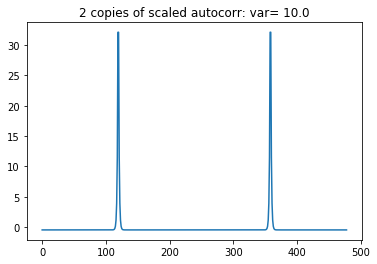

In [3]:
# Let's mimick a data array y, using AR1 red noise. 
# That only depends on autoregression at lag 1 (hence an "AR1 process")

# INPUTS
lag1_autocorr = 0.9  # Read off this value from corrcoef(y, roll(y,1))
variance = 10        # Read off this value from var(y) 
N = 240             # Read off this value from len(y)  



### CALCULATIONS AND PLOTTING
T_efold = 1.0/log(lag1_autocorr) # Units: number of array positions

### MAKE A YAUTO(X) ARRAY WITH THE RIGHT SIZE, VARIANCE, AND SPECTRUM
x = arange(N)              # A simple count array
xpert = x-mean(x)  
yauto = exp(- abs(xpert))  # Autocorrelation
# Scale it to have the given variance
yauto *= sqrt(variance/var(yauto))
# Remove the mean
yauto = detrend(yauto) 

### QUICK PLOT TO SEE IF IT IS SENSIBLE
xx = concatenate([x,x+max(x)])
plot(xx, concatenate([yauto,yauto]))
title('2 copies of scaled autocorr: var='+format(var(yauto),'5.3'));

## Make the complex spectrum, using fft
...normalizing by input series length, since science doesn't want the *values* of spectra to depend on sampling rate (and thus N)

In [4]:
N = len(yauto) 
spec = fft.fft(yauto) /N

# Unpack in all the usual ways: real (cos) and imaginary (sin)
specr = real(spec)
speci = imag(spec)

# Unpack in all the usual ways: amplitude and phase
ampli = abs(spec)
phase = angle(spec)

In [5]:
from scipy.linalg import logm, expm
logm?

## Synthesize with smooth red spectrum, random phase. 
Repeated ctrl-enter in the following cell will make one new realization after another to look at. Sobering with respect to monthly climate records in the instrumental era (a few hundred, autocorr = 0.9)

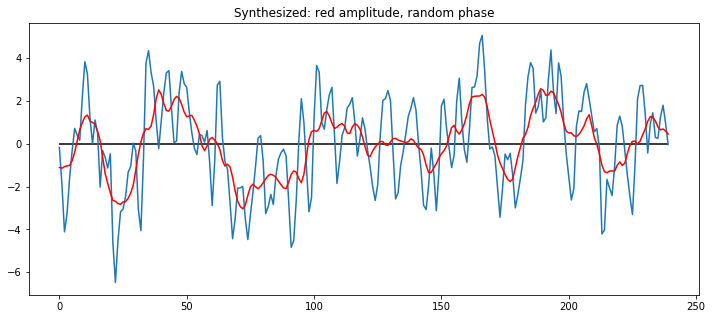

In [6]:
# Edit the spectrum's phase and amplitude:
syn_ampli = ampli

# Phase = rand() makes synthetic data
syn_phase = 2*pi*rand( len(phase) )

# Build the synthetic spectrum from real and imaginary parts
# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# And there is a near-zero imaginary part; strip it off with real()

syn_spec =(    syn_ampli*cos(syn_phase)   #real part
         + 1j* syn_ampli*sin(syn_phase) ) #imag part
syn_data = real( ifft(syn_spec)*N )


### PLOT the results
figure(6, figsize=[12,5])
yy = tile(syn_data,2)
# plot(xx,yy)
plot(x, syn_data)

# Overplot a smoothed version
kernel = N/10  # to emphasize lowest frequencies
yysmoo = np.convolve(yy, np.ones((10,))/10, mode='same')
ysmoo = np.convolve(syn_data, np.ones((10,))/10, mode='same')

#plot(xx, yysmoo, 'r', linewidth=3)
plot(x, ysmoo, 'r')

title('Synthesized: red amplitude, random phase');
hlines(0,min(x),max(x));

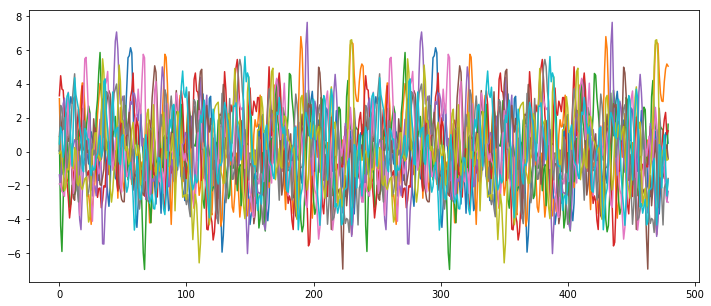

In [7]:
## More realizations with random phases

figure(6, figsize=[12,5])

for i in arange(10): 
    syn_phase = 2*pi*rand( len(phase) )
    
    syn_spec =(    syn_ampli*cos(syn_phase)   #real part
             + 1j* syn_ampli*sin(syn_phase) ) #imag part
    
    syn_data = real( ifft(syn_spec)*N )
    
    plot(tile(syn_data,2),)

### Synthetic data, from an autocorrelation function decay scale